In [1]:
import copy
import sys
sys.path.insert(0, "../../")
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_file_handler import Atom_File_handler
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Animator, Atom_Collection_Plotter
from classes.calculators.lennardjones import LJGauss
from classes.optimizers.md_simulator1 import MDTP_simulator
from classes.optimizers.random_struct_search import Line_searcher1
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
plt.rc('animation', html='jshtml')

In [2]:
class Atom_Plotter(Animator):
    def __init__(self, default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
    
    def __call__(self, atom_col, ax=None, plot_cell=False):
        self.plot_bonds(atom_col=atom_col, ax=ax)
        return super().__call__(atom_col, ax, plot_cell)

    def plot_bonds(self, atom_col, ax, r_cut=1.2):
        atom_positions =  atom_col.positions
        diff = atom_positions[np.newaxis, :, :] - atom_positions[:, np.newaxis, :]
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, np.inf)
        connections = (r < r_cut).astype(int)
        for i, row in enumerate(connections):
            for j, connection in enumerate(row):
                if connection == 1:
                    ax.plot([atom_positions[i][0], atom_positions[j][0]], [atom_positions[i][1], atom_positions[j][1]], c="k", lw=1)

In [3]:
positions = np.array([[0.0, 0.0],
                      [0.0,1.0],
                      [0.5,1.866],
                      [0.866,0.5],
                      [1.366,1.366],
                      [1.366, 2.366],
                      [2.193, 1.866],
                      [1.827, 0.5]]) + np.array([1.0, 1.0])*1e-3

scale_factor = 0.99

unit_cell = (np.array([2.72, 0.0])*scale_factor, np.array([0.0, 2.8])*scale_factor)

positions_tot = []
for i in [0.0, 1.0]:
    for j in [0.0, 1.0]:
        positions_tot.append(positions + i*unit_cell[0] + j*unit_cell[1])

positions_tot = np.array(positions_tot).reshape(len(positions)*4, 2)
unit_cell_big = (unit_cell[0]*2.0, unit_cell[1]*2.0)
relaxed_col = Atom_Collection(atomlist=[Atom(position=pos) for pos in positions_tot],pbc=True, unit_cell=unit_cell_big)
relaxed_col.calculator = LJGauss(gauss_eps=2.0, r0=1.9)
optimizer = Line_searcher1(atom_col=relaxed_col)
optimizer.run(N_max=100)
tot_relaxed_atoms = optimizer.best_atom_col

Text(0.5, 1.0, '$E_{pot}=$-365.949')

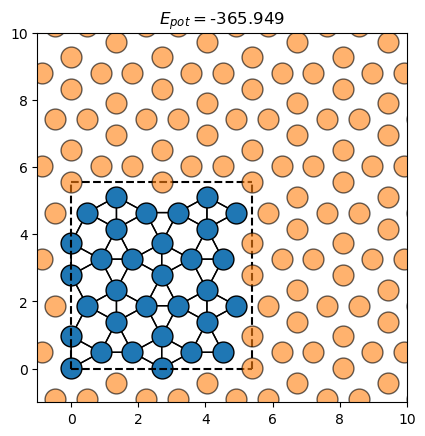

In [4]:
fig, ax = plt.subplots()
ax.set_xlim([-1.0, 10.0])
ax.set_ylim([-1.0, 10.0])
ax.set_aspect("equal")
atom_plotter = Atom_Plotter(markersize=15)
atom_plotter(atom_col=tot_relaxed_atoms, ax=ax, plot_cell=True)
atom_plotter.plot_several_cells(atom_col=tot_relaxed_atoms, ax=ax)
tot_relaxed_atoms.reset_plot_axes()
ax.set_title(r"$E_{pot}=$"+f"{round(tot_relaxed_atoms.get_potential_energy(),3)}")

In [5]:
temps = [0.20, 0.40, 0.60, 1.0, 1.2, 1.4, 1.6, 1.8, 1.9, 2.0]
atom_col_for_heatup = relaxed_col
total_logged_cols = []
for temp in temps:
    md_simulator = MDTP_simulator(atom_col=atom_col_for_heatup, temp=temp)
    md_simulator.run_MDsimulation(N_steps=600, gamma=1e-2, max_scale=5e-4)
    total_logged_cols.append(md_simulator.logged_atom_cols)
    atom_col_for_heatup = copy.deepcopy(md_simulator.logged_atom_cols[-1])

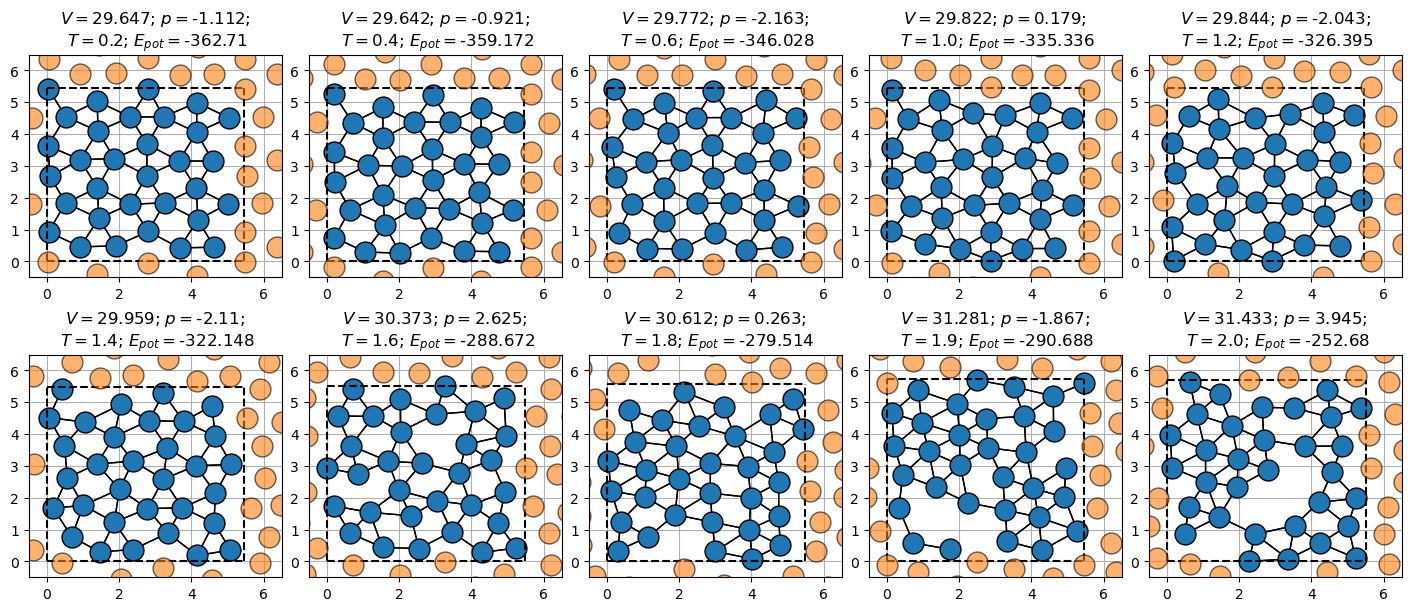

In [6]:
fig, axs = plt.subplots(2,5, figsize=(14,6), layout="constrained")

atom_plotter = Atom_Plotter(markersize=15)

for temp, atom_cols, ax in zip(temps, total_logged_cols, axs.flatten()):
    ax.grid()
    ax.set_xlim([-0.5, 6.5])
    ax.set_ylim([-0.5, 6.5])
    atom_col = atom_cols[-1]
    atom_plotter(atom_col=atom_col, ax=ax, plot_cell=True)
    atom_plotter.plot_several_cells(atom_col=atom_col, ax=ax)
    atom_col.reset_plot_axes()
    v = atom_col.get_volume()
    e_pot = atom_col.get_potential_energy()
    p = atom_col.get_pressure()
    ax.set_title(rf"$V=${round(v,3)}; $p=${round(p,3)};"+"\n"+rf" $T=${temp}; "+r"$E_{pot}=$"+f"{round(e_pot,3)}")

In [16]:
temps = [0.20, 0.40, 0.60, 0.80, 1.0, 1.2, 1.4, 1.5, 1.8, 2.2][::-1]
atom_col_for_cool_down = copy.deepcopy(total_logged_cols[-1][-1])
cool_logged_cols = []
for temp in temps:
    md_simulator = MDTP_simulator(atom_col=atom_col_for_cool_down, temp=temp)
    md_simulator.run_MDsimulation(N_steps=600, gamma=1e-2, max_scale=5e-4)
    cool_logged_cols.append(md_simulator.logged_atom_cols)
    atom_col_for_cool_down = copy.deepcopy(md_simulator.logged_atom_cols[-1])

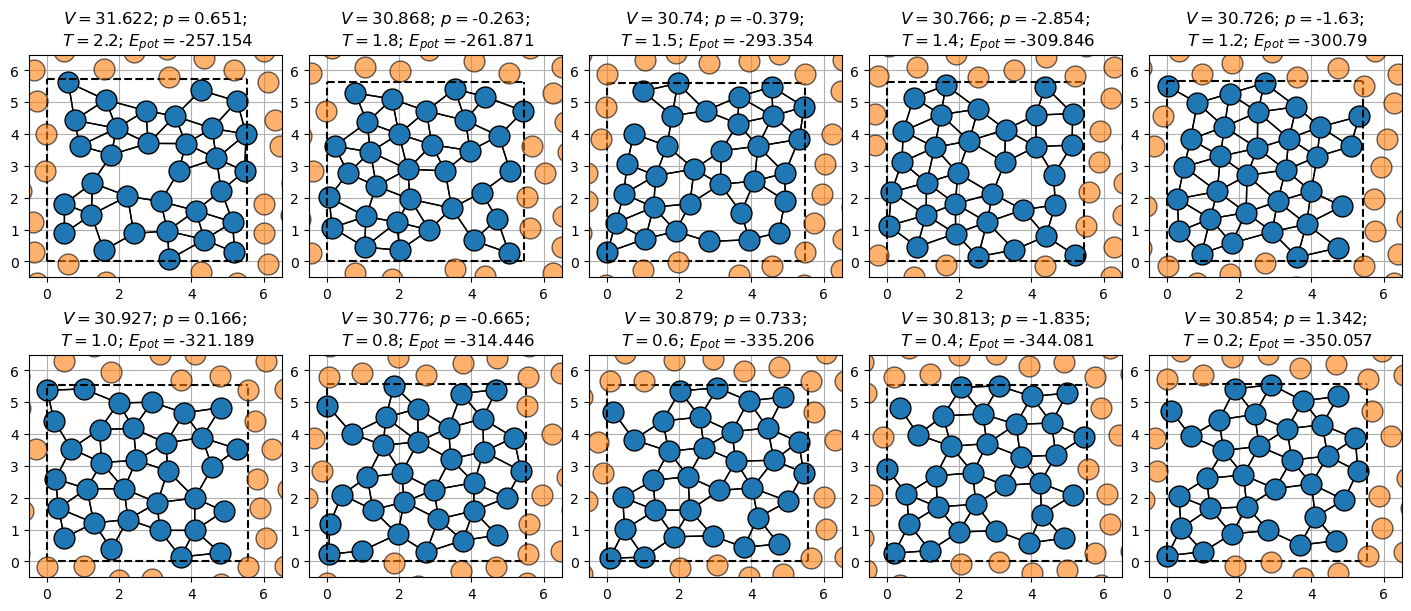

In [17]:
fig, axs = plt.subplots(2,5, figsize=(14,6), layout="constrained")

atom_plotter = Atom_Plotter(markersize=15)

for temp, atom_cols, ax in zip(temps, cool_logged_cols, axs.flatten()):
    ax.grid()
    ax.set_xlim([-0.5, 6.5])
    ax.set_ylim([-0.5, 6.5])
    atom_col = atom_cols[-1]
    atom_plotter(atom_col=atom_col, ax=ax, plot_cell=True)
    atom_plotter.plot_several_cells(atom_col=atom_col, ax=ax)
    atom_col.reset_plot_axes()
    v = atom_col.get_volume()
    e_pot = atom_col.get_potential_energy()
    p = atom_col.get_pressure()
    ax.set_title(rf"$V=${round(v,3)}; $p=${round(p,3)};"+"\n"+rf" $T=${temp}; "+r"$E_{pot}=$"+f"{round(e_pot,3)}")

In [19]:
atom_writer = Atom_File_handler()
total_heat_cols_reshaped = []
for logged_cols in total_logged_cols:
    for atom_col in logged_cols:
        total_heat_cols_reshaped.append(atom_col)

atom_writer.save_atom_collections(atom_cols=total_heat_cols_reshaped, filename="heated_atoms")
total_cool_cols_reshaped = []
for logged_cols in cool_logged_cols:
    for atom_col in logged_cols:
        total_cool_cols_reshaped.append(atom_col)

atom_writer.save_atom_collections(atom_cols=total_heat_cols_reshaped, filename="cooled_atoms")

In [7]:
from classes.descriptors import ConnectivityGraphSpectrum
con_desc_maker = ConnectivityGraphSpectrum()

total_logged_cols_reshaped = []

for logged_cols in total_logged_cols:
    for index in np.random.randint(0, len(logged_cols)-1, 30):
        total_logged_cols_reshaped.append(logged_cols[index])
        #total_logged_cols_reshaped+=logged_cols[index]
atom_poses = np.array([atom_col.positions for atom_col in total_logged_cols_reshaped])
connections = np.array([con_desc_maker.get_descriptor(atom_col=atom_col, A=1.2, r_min=2**(1.0/6.0)) for atom_col in total_logged_cols_reshaped])


In [8]:
from classes.pca import PCA
from classes.kmeans import KMeans


pca = PCA(n_components=2)
pca.fit(data=connections)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data=connections, init_mus=np.array([connections[np.random.randint(0, len(connections), 1)] for _ in range(n_clusters)]).squeeze(1))

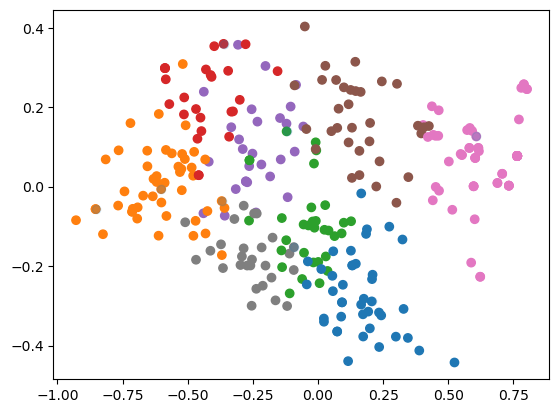

In [9]:
fig, ax = plt.subplots()
transed = pca.transform(data=connections)
transed1 = pca.transform(data=np.array([connections[np.random.randint(0, len(connections), 1)] for _ in range(n_clusters)]).squeeze(1))
labels = kmeans.predict(connections)
ax.scatter(transed[:,0], transed[:,1], color=[f"C{label}" for label in labels])
ax.plot(transed1[:,0], transed1[:,1], 'o', alpha=0.2)

KeyboardInterrupt: 

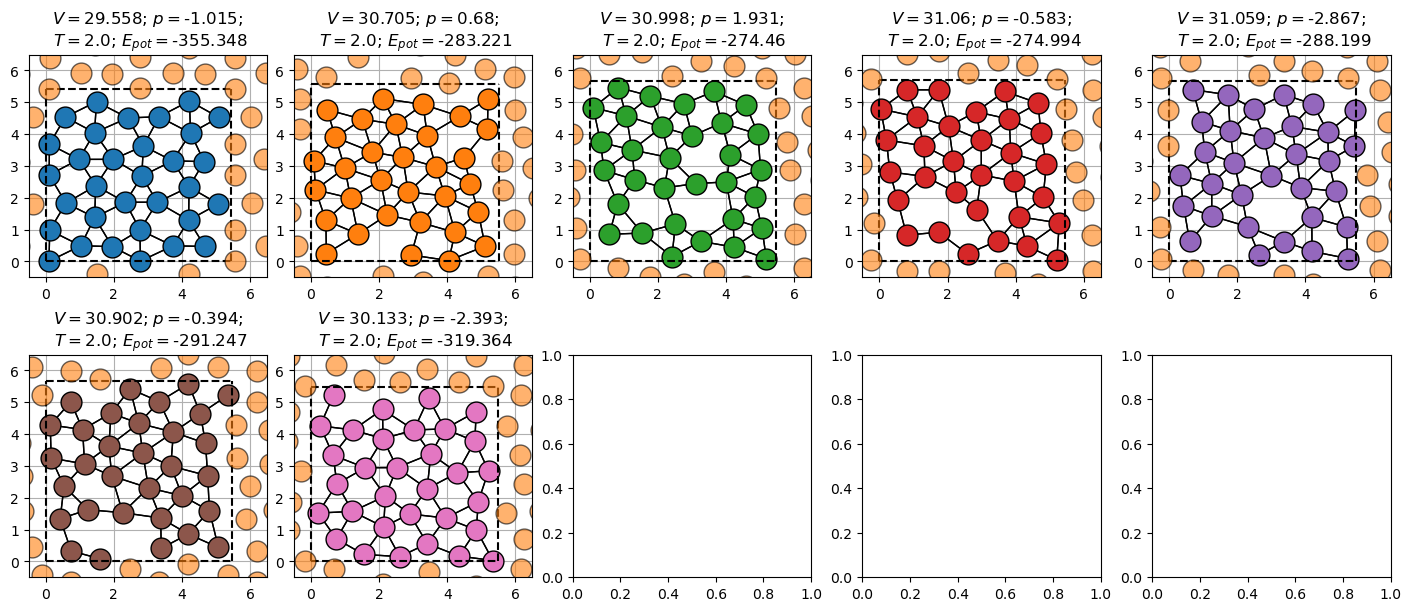

In [15]:
fig, axs = plt.subplots(2,5, figsize=(14,6), layout="constrained")
for label, ax in zip(range(8), axs.flatten()):
    pred_made = False
    while pred_made == False:
        atom_col = total_logged_cols_reshaped[np.random.randint(0, len(total_logged_cols_reshaped), 1)[0]]
        #print(atom_col)
        con = con_desc_maker.get_descriptor(atom_col)
        label_pred = kmeans.predict([con])[0]
        #print(label_pred)
        if label_pred == label:
            ax.grid()
            atom_plotter = Atom_Plotter(default_cols=(f"C{label}", "C1"), markersize=15)
            ax.set_xlim([-0.5, 6.5])
            ax.set_ylim([-0.5, 6.5])
            atom_plotter(atom_col=atom_col, ax=ax, plot_cell=True)
            atom_plotter.plot_several_cells(atom_col=atom_col, ax=ax)
            atom_col.reset_plot_axes()
            v = atom_col.get_volume()
            e_pot = atom_col.get_potential_energy()
            p = atom_col.get_pressure()
            ax.set_title(rf"$V=${round(v,3)}; $p=${round(p,3)};"+"\n"+rf" $T=${temp}; "+r"$E_{pot}=$"+f"{round(e_pot,3)}")
            pred_made = True

In [ ]:
vs = np.sqrt(0.25/1.0)*np.random.randn(10000, 2)

In [ ]:
v_norm = np.linalg.norm(vs, axis=1)
hist, bins = np.histogram(v_norm, bins=np.arange(0.0, 2.0, 0.01))
print(hist)

In [ ]:
fig, ax = plt.subplots()
ax.stairs(hist, bins)

In [ ]:
np.random.randint(0, len(logged_cols)-1, 50)[0]